In [1]:
import logging

logger = logging.getLogger(__name__)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [49]:
from os import cpu_count
import subprocess

def make(targets, num_processes=1, directory='.'):
    """Uses GNU make to produce targets.

    Parameters
    ----------
    targets : str or iterable of str
        The names of the targets. If only a string is provided, it specifies the name of the only target.
    num_processes : int or 'all', optional
        The number of threads used to produce the targets. If all, then the number of threads is equal to
        the number of available CPU cores. One thread will be used when unspecified.
    directory : str, optional
        The pathname of a directory in which the targets will be made. The current working directory will
        be used when unspecified.
    """
    
    if num_processes == 'all':
        num_processes = cpu_count()
    
    if isinstance(targets, str):
        target = targets
        logger.info(
            'Making target {} using {} threads in directory {}'.format(
                target,
                num_processes,
                directory,
            )
        )
    else:
        targets = list(targets)
        target = ' '.join(targets)
        logger.info(
            'Making {} targets using {} threads in directory {}'.format(
                len(targets),
                num_processes,
                directory,
            )
        )

    command = 'nice -n 19 make -j {} -C {} {}'.format(num_processes, directory, target)
    exit_code = subprocess.call(command, shell=True)
    assert exit_code == 0, 'GNU Make exited with code {}'.format(return_code)

In [29]:
%matplotlib inline

from itertools import cycle, product

import matplotlib.pyplot as plt
from matplotlib import rcParams

def get_line_formats():
    """Produces an iterable of line colors and formats.
    
    Returns
    -------
    iterable of (str, str)
        An iterable of line colors and formats.
    """
    
    return cycle(product(['C{}'.format(colornum) for colornum in range(10)], ['-', '--', '-.', ':']))

In [4]:
from gensim.models import KeyedVectors
import numpy as np

2019-04-08 23:10:31,735 : INFO : 'pattern' package not found; tag filters are not available for English


In [24]:
from itertools import chain

import majka
from majka import Majka

make('w-lt.en.fsa')
morph = Majka("w-lt.en.fsa")
morph.flags |= majka.IGNORE_CASE
morph.tags = True

embedding_names = tuple(chain(
    ('uniform', 'exponential'),
    ('zipf-mk{}'.format(mark) for mark in range(1, 15)),
))

def tag_word(word):
    """Returns parts-of-speech tags for a word.
    
    Parameters
    ----------
    word : str
        A word.
    
    Returns
    -------
    set
        The parts-of-speech tags for the word.
    """
    
    return set(lemma["tags"]["other"] for lemma in morph.find(str(word)))

2019-04-09 18:41:19,380 : INFO : Making target w-lt.en.fsa


# Embedding Sparsification
Every feature of a Word2Bits word embedding contains only a single bit of information, but the features don't correlate with high-level features parts of speech, and a negative value does not necessarily signify a disabled feature, which hurts interpretability, performance, and potential applications.

We aim to construct “lexical” Word2Bits embeddings that are highly correlated with parts of speech and where the lack of a feature is signified by a zero bit. Our approach is to change the loss function, so that sparse embeddings are enforced. This enforcement is non-uniform, so that feature frequencies follow the Zipf distribution like words are known to do.

## Loss Functions

In [13]:
lambdas = 0.0, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 0.999, 1.0

def plot_feature_frequency(embedding_name):
    """Plots the feature frequency of word embeddings.

    Parameters
    ----------
    embedding_name : str
        The name of the word embeddings.
    """
    
    plt.figure(figsize=(15, 5))
    for l in lambdas:
        filename = 'vectors/{}_sparsification/1b_1000d_vectors_{}_e10_nonbin'.format(embedding_name, l)
        make(filename)
        embeddings = KeyedVectors.load_word2vec_format(filename, binary=False)
        feature_matrix = embeddings.vectors
        feature_frequency = sorted(np.sign(feature_matrix.T).clip(0, 1).sum(axis=1), reverse=True)
        plt.plot(feature_frequency, label=r'$\lambda = {}$'.format(l))
    plt.xlabel('feature rank')
    plt.ylabel('feature frequency')
    plt.xlim(1, 1000)
    plt.ylim(1, 10**5)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig('figures/{}.pdf'.format(embedding_name))
    plt.show()

### Uniformly Sparse Embeddings
We update the Word2Bits loss function $J(\mathbf{u}_o, \hat{\mathbf{v}}_c)$ from $$\begin{align*}
J(\mathbf{u}_o, \hat{\mathbf{v}}_c) &= \alpha\cdot\left(-\log\left(\sigma\left((\mathbf{u}_o)^T\hat{\mathbf{v}}_c\right)\right) - \sum_{i=1}^k\log\left(\sigma\left((-\mathbf{u}_i)^T\hat{\mathbf{v}}_c\right)\right)\right) \\
                                    &= \alpha\cdot\left(-\log\left(\sigma\left(\sum_{j=1}^D u_{oj}\cdot\hat{v}_{cj}\right)\right) - \sum_{i=1}^k\log\left(\sigma\left(\sum_{j=1}^D -u_{ij}\cdot\hat{v}_{cj}\right)\right)\right) \\
\end{align*}$$
to $$\begin{align*}
J'(\mathbf{u}_o, \hat{\mathbf{v}}_c) &= \alpha\cdot\left((1-\lambda)\cdot J(\mathbf{u}_o, \hat{\mathbf{v}}_c)+ \lambda\cdot\left(\sum_{j=1}^{D}\left(u_{oj} + \sum_{-w+o\leq i\leq w+o, i\neq o}v_{ij}\right)\right)\right), \\
\end{align*}$$ where $\alpha$ is the learning rate, and $\lambda\in[0, 1]$ specifies our insistence that the word embeddings be sparse. The following plot shows feature frequencies as we change $\lambda$.

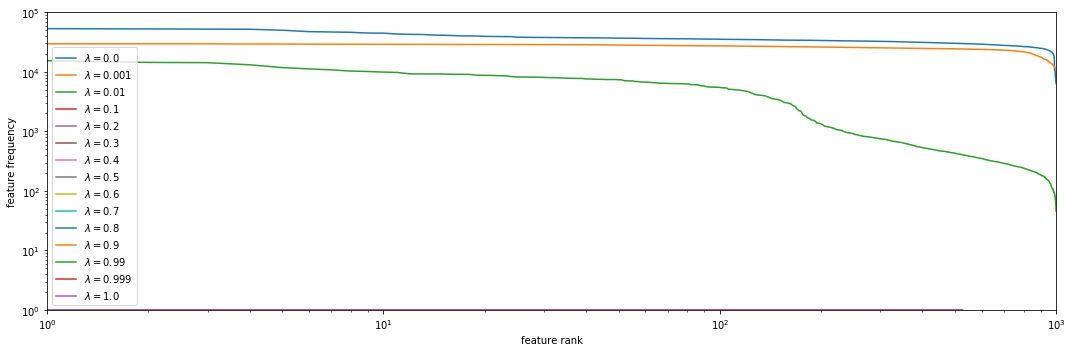

In [5]:
plot_feature_frequency('uniform')

### Zipf Sparse Embeddings
#### Inverse Zipf embeddings
We update the Word2Bits loss function $J(\mathbf{u}_o, \hat{\mathbf{v}}_c)$ from
$$\begin{align*}
J(\mathbf{u}_o, \hat{\mathbf{v}}_c) &= \alpha\cdot\left(-\log\left(\sigma\left((\mathbf{u}_o)^T\hat{\mathbf{v}}_c\right)\right) - \sum_{i=1}^k\log\left(\sigma\left((-\mathbf{u}_i)^T\hat{\mathbf{v}}_c\right)\right)\right) \\
                                    &= \alpha\cdot\left(-\log\left(\sigma\left(\sum_{j=1}^D u_{oj}\cdot\hat{v}_{cj}\right)\right) - \sum_{i=1}^k\log\left(\sigma\left(\sum_{j=1}^D -u_{ij}\cdot\hat{v}_{cj}\right)\right)\right) \\
\end{align*}$$
to $$\begin{align*}
J'_{\text{Mk1}}(\mathbf{u}_o, \hat{\mathbf{v}}_c) &= \alpha\cdot\left(\left(-\log\left(\sigma\left(\sum_{j=1}^D \left(1-\lambda\cdot\frac jD\right)\cdot u_{oj}\cdot\hat{v}_{cj}\right)\right) - \sum_{i=1}^k\log\left(\sigma\left(\sum_{j=1}^D \left(1-\lambda\cdot\frac jD\right)\cdot -u_{ij}\cdot\hat{v}_{cj}\right)\right)\right)\right. \\
                                     &+ \left.\left(\sum_{j=1}^{D}\lambda\cdot\frac jD\cdot\left(u_{oj} + \sum_{-w+o\leq i\leq w+o, i\neq o}v_{ij}\right)\right)\right), \\
\end{align*}$$ where $\alpha$ is the learning rate, and $\frac jD$ modulates $\lambda$ proportionally to the inverse PMF of the Zipf distribution ($s=1$). The following plot shows feature frequencies as we change $\lambda$.

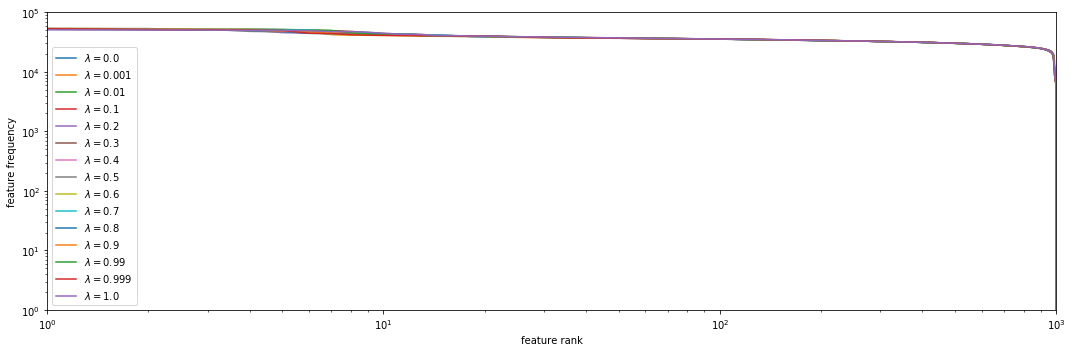

In [6]:
plot_feature_frequency('zipf-mk1')

As an alternative loss function uses $\alpha$ only as the learning rate for $J$: $$\begin{align*}
J'_{\text{Mk2}}(\mathbf{u}_o, \hat{\mathbf{v}}_c) &= \alpha\cdot\left(\left(-\log\left(\sigma\left(\sum_{j=1}^D \left(1-\lambda\cdot\frac jD\right)\cdot u_{oj}\cdot\hat{v}_{cj}\right)\right) - \sum_{i=1}^k\log\left(\sigma\left(\sum_{j=1}^D \left(1-\lambda\cdot\frac jD\right)\cdot -u_{ij}\cdot\hat{v}_{cj}\right)\right)\right)\right) \\
                                     &+ \left(\sum_{j=1}^{D}\lambda\cdot\frac jD\cdot\left(u_{oj} + \sum_{-w+o\leq i\leq w+o, i\neq o}v_{ij}\right)\right). \\
\end{align*}$$

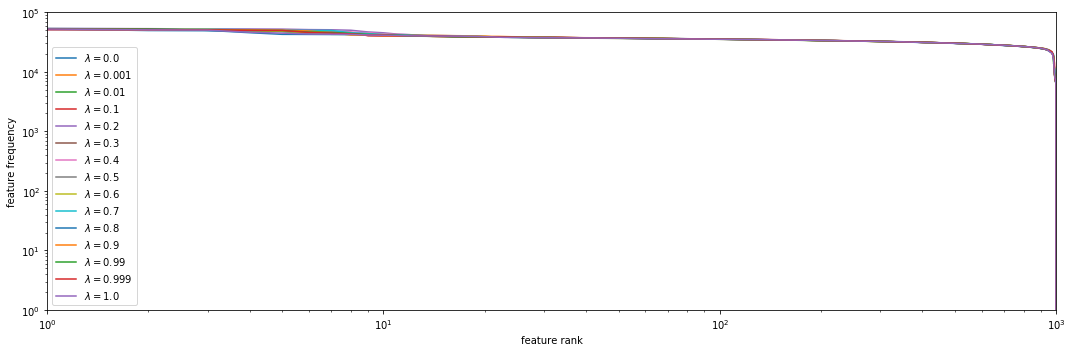

In [7]:
plot_feature_frequency('zipf-mk2')

As an alternative loss function does not use $\lambda$ in $J$ at all: $$\begin{align*}
J'_{\text{Mk3}}(\mathbf{u}_o, \hat{\mathbf{v}}_c) &= \alpha\cdot J(\mathbf{u}_o, \hat{\mathbf{v}}_c)+ \left(\sum_{j=1}^{D}\lambda\cdot\frac jD\cdot\left(u_{oj} + \sum_{-w+o\leq i\leq w+o, i\neq o}v_{ij}\right)\right). \\
\end{align*}$$

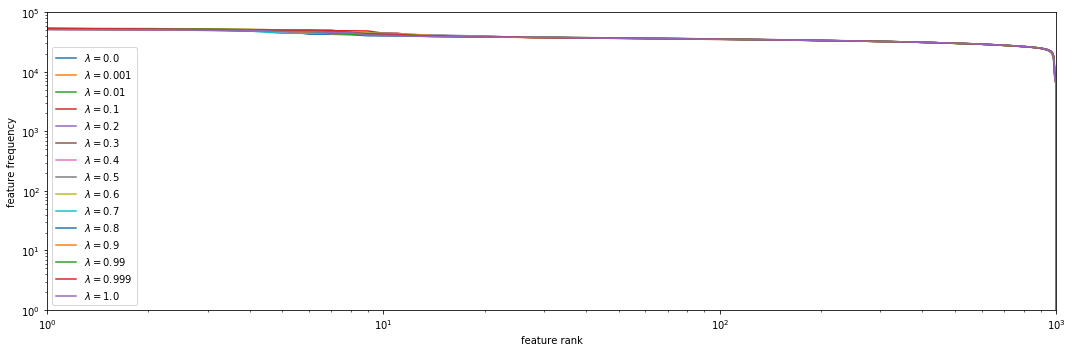

In [12]:
plot_feature_frequency('zipf-mk3')

Moving $J'_{\text{Mk2}}$ closer to `4c6f4c3`, we introduce a mistake to the gradient, producing a different loss function $J'_{\text{Mk7}}$.

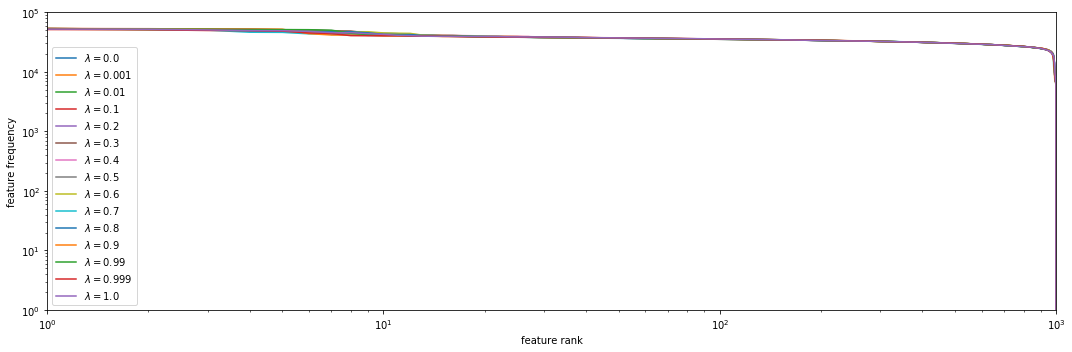

In [13]:
plot_feature_frequency('zipf-mk7')

Moving $J'_{\text{Mk7}}$ closer to `4c6f4c3`, we index from zero instead of one in $\lambda\cdot\frac jD$: $$\begin{align*}
J'_{\text{Mk8}}(\mathbf{u}_o, \hat{\mathbf{v}}_c) &= \alpha\cdot\left(\left(-\log\left(\sigma\left(\sum_{j=1}^D \left(1-\lambda\cdot\frac{j-1}D\right)\cdot u_{oj}\cdot\hat{v}_{cj}\right)\right) - \sum_{i=1}^k\log\left(\sigma\left(\sum_{j=1}^D \left(1-\lambda\cdot\frac{j-1}D\right)\cdot -u_{ij}\cdot\hat{v}_{cj}\right)\right)\right)\right) \\
                                     &+ \left(\sum_{j=1}^{D}\lambda\cdot\frac{j-1}D\cdot\left(u_{oj} + \sum_{-w+o\leq i\leq w+o, i\neq o}v_{ij}\right)\right). \\
\end{align*}$$

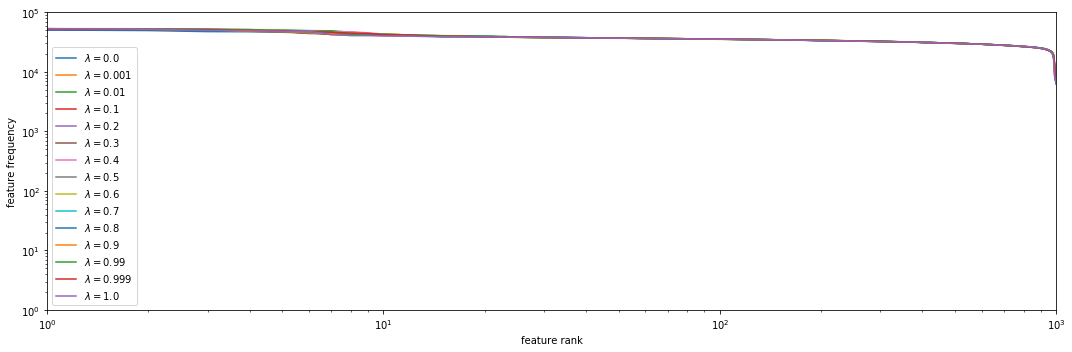

In [14]:
plot_feature_frequency('zipf-mk8')

Moving $J'_{\text{Mk8}}$ closer to `4c6f4c3`, we transform the sparsification factor using the sigmoid ($\sigma$) function: $$\begin{align*}
J'_{\text{Mk9}}(\mathbf{u}_o, \hat{\mathbf{v}}_c) &= \alpha\cdot\left(\left(-\log\left(\sigma\left(\sum_{j=1}^D \left(1-\lambda\cdot\frac{j-1}D\right)\cdot u_{oj}\cdot\hat{v}_{cj}\right)\right) - \sum_{i=1}^k\log\left(\sigma\left(\sum_{j=1}^D \left(1-\lambda\cdot\frac{j-1}D\right)\cdot -u_{ij}\cdot\hat{v}_{cj}\right)\right)\right)\right) \\
                                     &+ \left(\sum_{j=1}^{D}\lambda\cdot\frac{j-1}D\cdot\left(\sigma(u_{oj}) + \sum_{-w+o\leq i\leq w+o, i\neq o}\sigma(v_{ij})\right)\right). \\
\end{align*}$$

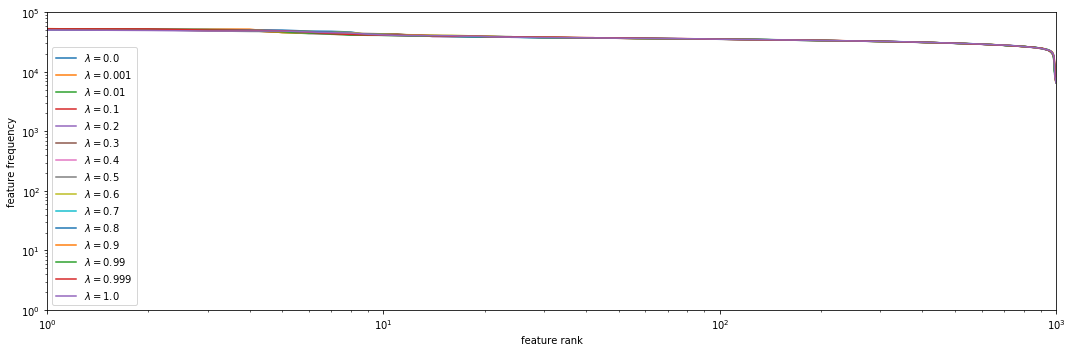

In [17]:
plot_feature_frequency('zipf-mk9')

Switching to `4c6f4c3`, we produce the loss function $J'_{\text{Mk13}}$.

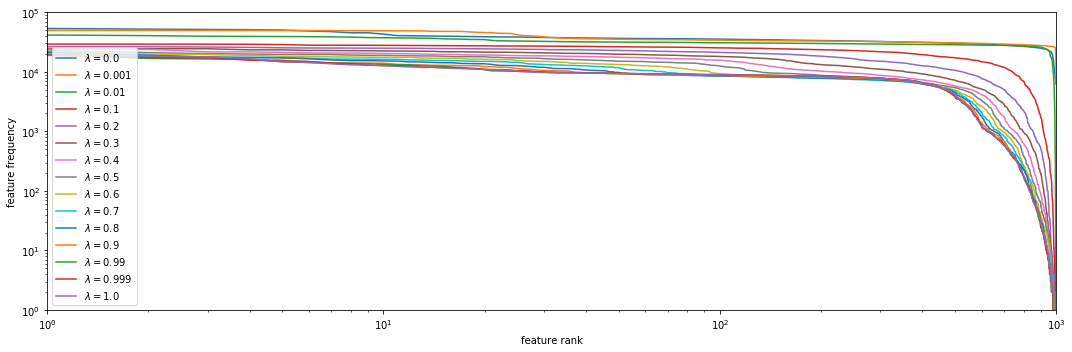

In [20]:
plot_feature_frequency('zipf-mk13')

#### Forward Zipf embeddings
We update the Word2Bits loss function $J(\mathbf{u}_o, \hat{\mathbf{v}}_c)$ from
$$\begin{align*}
J(\mathbf{u}_o, \hat{\mathbf{v}}_c) &= \alpha\cdot\left(-\log\left(\sigma\left((\mathbf{u}_o)^T\hat{\mathbf{v}}_c\right)\right) - \sum_{i=1}^k\log\left(\sigma\left((-\mathbf{u}_i)^T\hat{\mathbf{v}}_c\right)\right)\right) \\
                                    &= \alpha\cdot\left(-\log\left(\sigma\left(\sum_{j=1}^D u_{oj}\cdot\hat{v}_{cj}\right)\right) - \sum_{i=1}^k\log\left(\sigma\left(\sum_{j=1}^D -u_{ij}\cdot\hat{v}_{cj}\right)\right)\right) \\
\end{align*}$$
to $$\begin{align*}
J'_{\text{Mk4}}(\mathbf{u}_o, \hat{\mathbf{v}}_c) &= \alpha\cdot\left(\left(-\log\left(\sigma\left(\sum_{j=1}^D \left(1-\frac\lambda j\right)\cdot u_{oj}\cdot\hat{v}_{cj}\right)\right) - \sum_{i=1}^k\log\left(\sigma\left(\sum_{j=1}^D \left(1-\frac\lambda j\right)\cdot -u_{ij}\cdot\hat{v}_{cj}\right)\right)\right)\right. \\
                                     &+ \left.\left(\sum_{j=1}^{D}\frac\lambda j\cdot\left(u_{oj} + \sum_{-w+o\leq i\leq w+o, i\neq o}v_{ij}\right)\right)\right), \\
\end{align*}$$ where $\alpha$ is the learning rate, and $j$ modulates $\lambda$ proportionally to the PMF of the Zipf distribution ($s=1$). The following plot shows feature frequencies as we change $\lambda$.

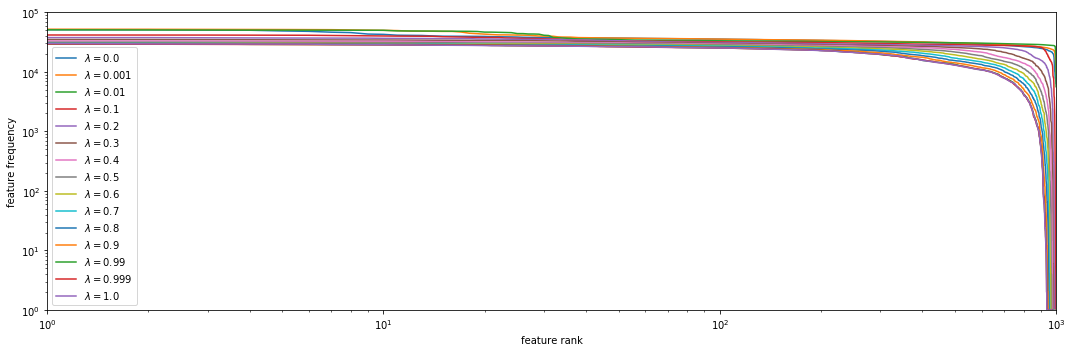

In [8]:
plot_feature_frequency('zipf-mk4')

As an alternative loss function uses $\alpha$ only as the learning rate for $J$: $$\begin{align*}
J'_{\text{Mk5}}(\mathbf{u}_o, \hat{\mathbf{v}}_c) &= \alpha\cdot\left(\left(-\log\left(\sigma\left(\sum_{j=1}^D \left(1-\frac\lambda j\right)\cdot u_{oj}\cdot\hat{v}_{cj}\right)\right) - \sum_{i=1}^k\log\left(\sigma\left(\sum_{j=1}^D \left(1-\frac\lambda j\right)\cdot -u_{ij}\cdot\hat{v}_{cj}\right)\right)\right)\right) \\
                                     &+ \left(\sum_{j=1}^{D}\frac\lambda j\cdot\left(u_{oj} + \sum_{-w+o\leq i\leq w+o, i\neq o}v_{ij}\right)\right). \\
\end{align*}$$

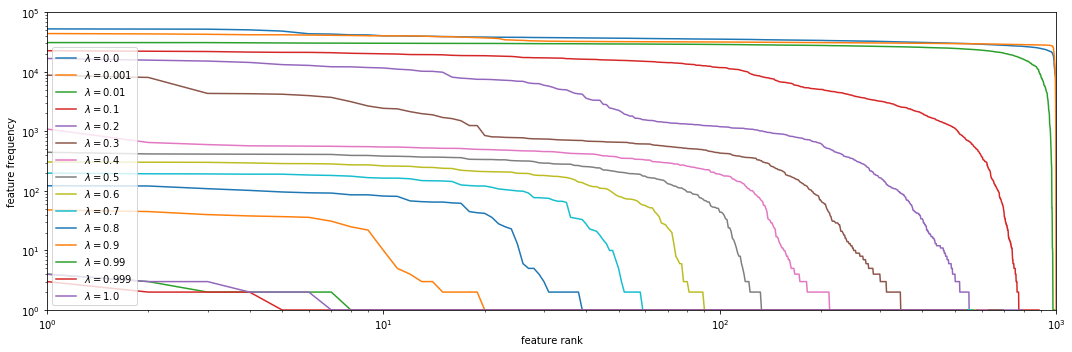

In [9]:
plot_feature_frequency('zipf-mk5')

As an alternative loss function does not use $\lambda$ in $J$ at all: $$\begin{align*}
J'_{\text{Mk6}}(\mathbf{u}_o, \hat{\mathbf{v}}_c) &= \alpha\cdot J(\mathbf{u}_o, \hat{\mathbf{v}}_c)+ \left(\sum_{j=1}^{D}\frac\lambda j\cdot\left(u_{oj} + \sum_{-w+o\leq i\leq w+o, i\neq o}v_{ij}\right)\right). \\
\end{align*}$$

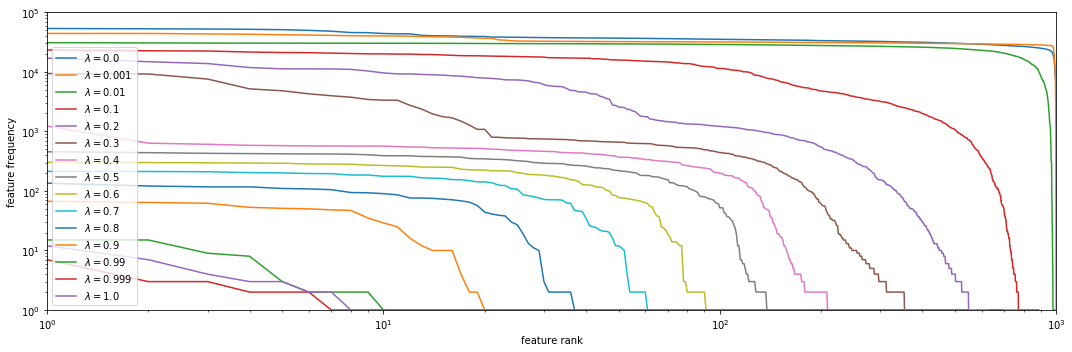

In [10]:
plot_feature_frequency('zipf-mk6')

Moving $J'_{\text{Mk5}}$ closer to `4a40595`, we introduce a mistake to the gradient, producing a different loss function $J'_{\text{Mk10}}$.

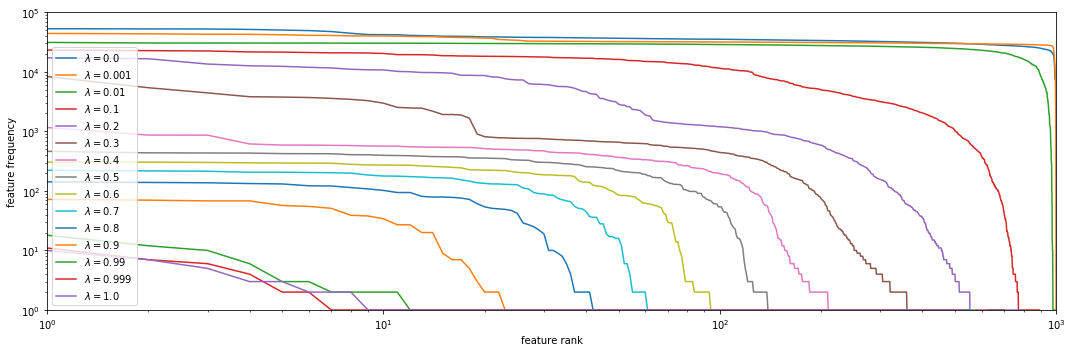

In [15]:
plot_feature_frequency('zipf-mk10')

Moving $J'_{\text{Mk10}}$ closer to `4a40595`, we index from zero instead of one in $\lambda\cdot\frac jD$: $$\begin{align*}
J'_{\text{Mk11}}(\mathbf{u}_o, \hat{\mathbf{v}}_c) &= \alpha\cdot\left(\left(-\log\left(\sigma\left(\sum_{j=1}^D \left(1-\frac\lambda{j-1}\right)\cdot u_{oj}\cdot\hat{v}_{cj}\right)\right) - \sum_{i=1}^k\log\left(\sigma\left(\sum_{j=1}^D \left(1-\frac\lambda{j-1}\right)\cdot -u_{ij}\cdot\hat{v}_{cj}\right)\right)\right)\right) \\
                                     &+ \left(\sum_{j=1}^{D}\frac\lambda{j-1}\cdot\left(u_{oj} + \sum_{-w+o\leq i\leq w+o, i\neq o}v_{ij}\right)\right). \\
\end{align*}$$

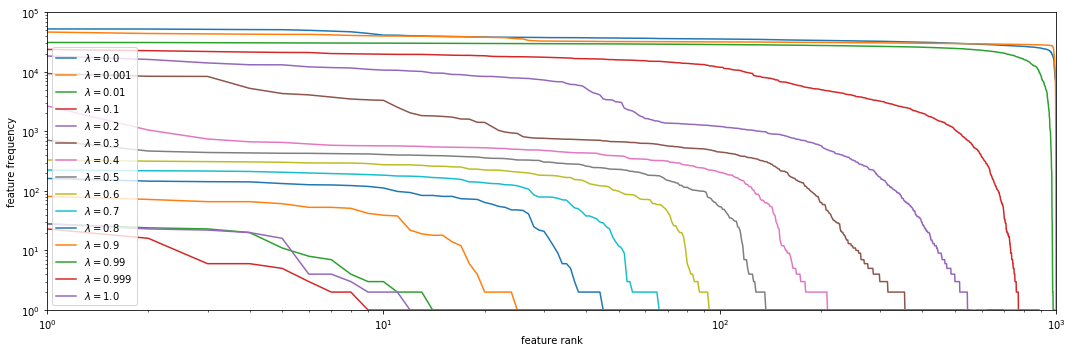

In [16]:
plot_feature_frequency('zipf-mk11')

Moving $J'_{\text{Mk11}}$ closer to `4a40595`, we transform the sparsification factor using the sigmoid ($\sigma$) function: $$\begin{align*}
J'_{\text{Mk12}}(\mathbf{u}_o, \hat{\mathbf{v}}_c) &= \alpha\cdot\left(\left(-\log\left(\sigma\left(\sum_{j=1}^D \left(1-\frac\lambda{j-1}\right)\cdot u_{oj}\cdot\hat{v}_{cj}\right)\right) - \sum_{i=1}^k\log\left(\sigma\left(\sum_{j=1}^D \left(1-\frac\lambda{j-1}\right)\cdot -u_{ij}\cdot\hat{v}_{cj}\right)\right)\right)\right) \\
                                     &+ \left(\sum_{j=1}^{D}\frac\lambda{j-1}\cdot\left(\sigma(u_{oj}) + \sum_{-w+o\leq i\leq w+o, i\neq o}\sigma(v_{ij})\right)\right). \\
\end{align*}$$

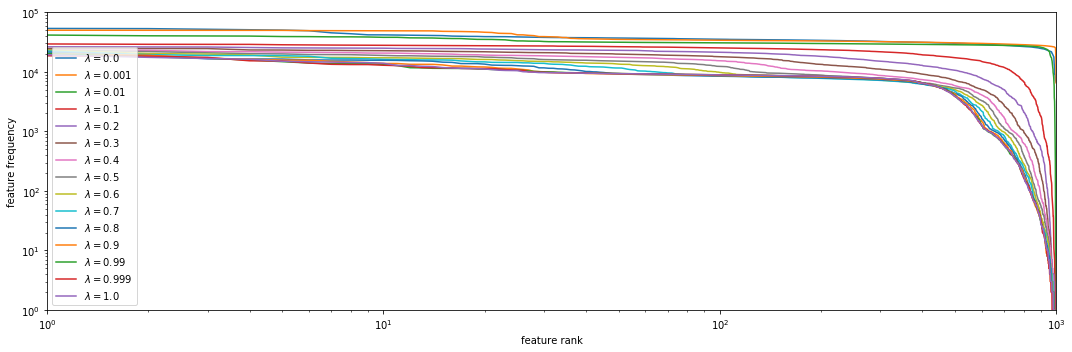

In [18]:
plot_feature_frequency('zipf-mk12')

Switching to `4a40595`, we produce the loss function $J'_{\text{Mk14}}$.

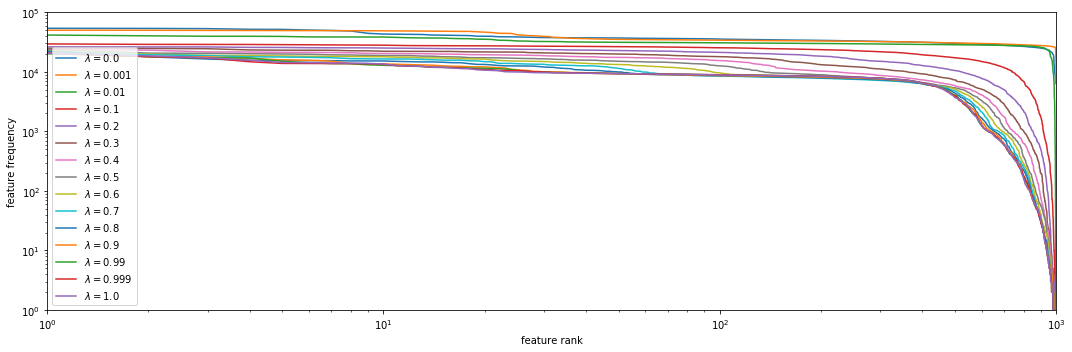

In [21]:
plot_feature_frequency('zipf-mk14')

### Exponential Sparse Embeddings
We update the Word2Bits loss function $J(\mathbf{u}_o, \hat{\mathbf{v}}_c)$ from
$$\begin{align*}
J(\mathbf{u}_o, \hat{\mathbf{v}}_c) &= \alpha\cdot\left(-\log\left(\sigma\left((\mathbf{u}_o)^T\hat{\mathbf{v}}_c\right)\right) - \sum_{i=1}^k\log\left(\sigma\left((-\mathbf{u}_i)^T\hat{\mathbf{v}}_c\right)\right)\right) \\
                                    &= \alpha\cdot\left(-\log\left(\sigma\left(\sum_{j=1}^D u_{oj}\cdot\hat{v}_{cj}\right)\right) - \sum_{i=1}^k\log\left(\sigma\left(\sum_{j=1}^D -u_{ij}\cdot\hat{v}_{cj}\right)\right)\right) \\
\end{align*}$$
to $$\begin{align*}
J'(\mathbf{u}_o, \hat{\mathbf{v}}_c) &= \alpha\cdot\left(\left(-\log\left(\sigma\left(\sum_{j=1}^D (1-\lambda)^j\cdot u_{oj}\cdot\hat{v}_{cj}\right)\right) - \sum_{i=1}^k\log\left(\sigma\left(\sum_{j=1}^D (1-\lambda)^j\cdot -u_{ij}\cdot\hat{v}_{cj}\right)\right)\right)\right. \\
                                     &+ \left.\left(\sum_{j=1}^{D}\left(1-(1-\lambda)^j\right)\cdot\left(u_{oj} + \sum_{-w+o\leq i\leq w+o, i\neq o}v_{ij}\right)\right)\right), \\
\end{align*}$$ where $\alpha$ is the learning rate, and $j$ modulates $\lambda$ exponentially. The following plot shows feature frequencies as we change $\lambda$.

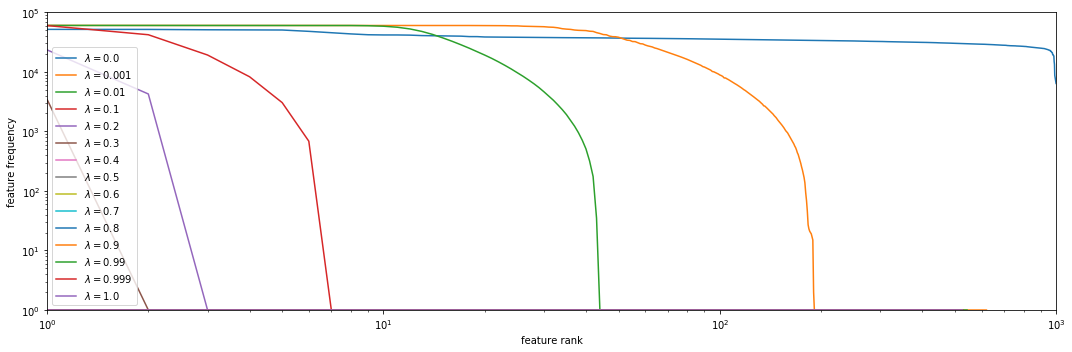

In [11]:
plot_feature_frequency('exponential')

## Evaluation
### Correlation with Parts of Speech
To test the hypothesis that “lexical” Word2Bits embeddings are highly correlated with high-level features such as parts of speech, we plot the minimum, maximum, and mean absolute correlation coefficient (Pearson's $r$) of word embedding features and parts-of-speech tags for all the above word embeddings and all values of $\lambda$.

In [62]:
def get_corrcoeff(embeddings, statistic_name):
    """Returns a statistic of the absolute Pearson's r of word embedding features and parts-of-speech tags.
    
    Parameters
    ----------
    embeddings : gensim.models.keyedvectors.Word2VecKeyedVectors
        Word embeddings.
    statistic_name : {'minimum', 'maximum', 'mean'}
        The name of the statistic.
    
    Returns
    -------
    np.float64
        The statistic of the absolute Pearson's r of word embedding features and parts-of-speech tag.
    """
    
    words = embeddings.index2entity
    tags = list(set.union(*map(tag_word, words)))

    feature_matrix = embeddings.vectors.clip(0, 1).astype(bool)
    tag_matrix = np.array([[(tag in tag_word(word)) for tag in tags] for word in words], dtype=bool)

    num_features = feature_matrix.shape[1]
    num_tags = len(tags)

    corrcoeff = np.nan_to_num(np.corrcoef(feature_matrix.T, tag_matrix.T))
    corrcoeff = np.abs(corrcoeff[:num_features, num_features:num_features + num_tags])
    
    if statistic_name == 'minimum':
        return corrcoeff.min()
    elif statistic_name == 'maximum':
        return corrcoeff.max()
    elif statistic_name == 'mean':
        return corrcoeff.mean()
    
    return max_corrcoeff

def plot_corrcoeff(embedding_names, statistic_name):
    """Plots a statistic of the absolute Pearson's r of word embedding features and parts-of-speech tags.

    Parameters
    ----------
    embedding_names : iterable of str
        The names of the word embeddings.
    statistic_name : {'minimum', 'maximum', 'mean'}
        The name of the statistic.
    """
    
    line_formats = get_line_formats()
    plt.figure(figsize=(15, 5))
    for embedding_name in embedding_names:
        statistics = []
        for l in lambdas:
            filename = 'vectors/{}_sparsification/1b_1000d_vectors_{}_e10_nonbin'.format(embedding_name, l)
            make(filename)
            embeddings = KeyedVectors.load_word2vec_format(filename, binary=False)
            statistics.append(get_corrcoeff(embeddings, statistic_name))
        color, linestyle = next(line_formats)
        plt.plot(lambdas, statistics, label=embedding_name, linestyle=linestyle, color=color)
    plt.xlabel(r'$\lambda$')
    plt.ylabel('{} abs. correlation coefficient'.format(statistic_name))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig('figures/{}_corrcoeffs.pdf'.format(statistic_name))
    plt.show()

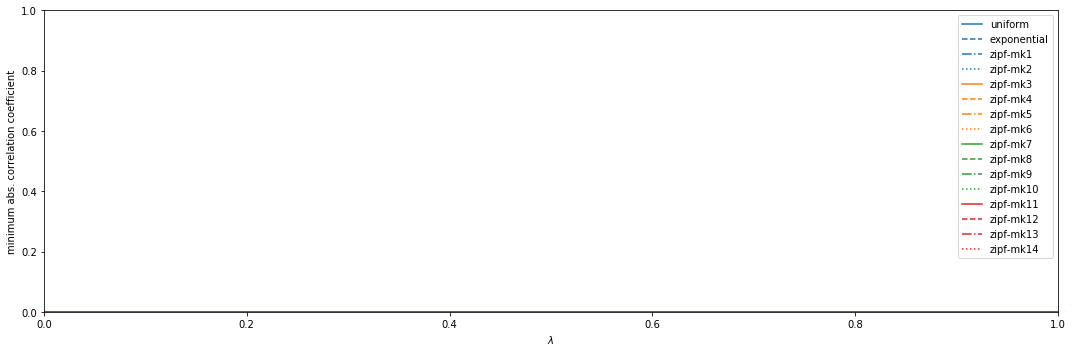

In [63]:
plot_corrcoeff(embedding_names, 'minimum')

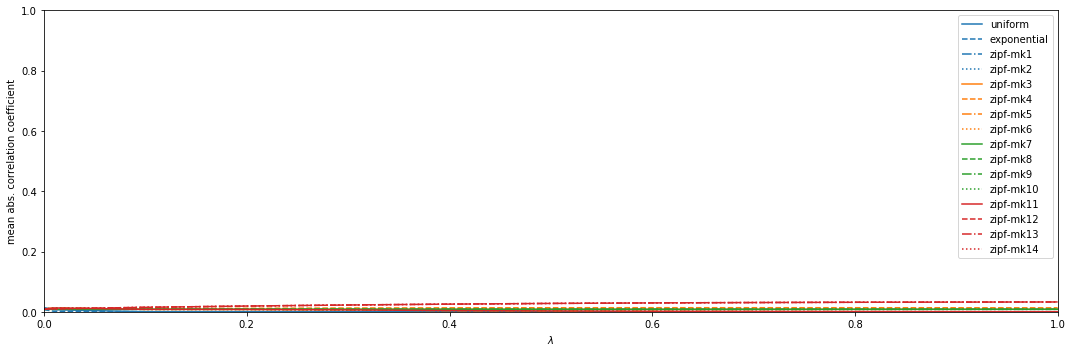

In [64]:
plot_corrcoeff(embedding_names, 'mean')

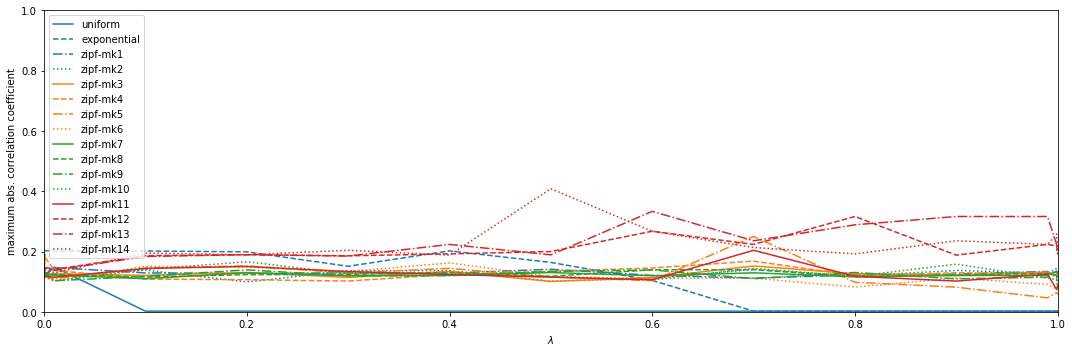

In [65]:
plot_corrcoeff(embedding_names, 'maximum')

### Google Analogy Task
We plot the on the syntactic, semantic, and total accuracies at the Google analogy task for all the above word embeddings and all values of $\lambda$.

In [58]:
import math
import re

def get_accuracy(f, accuracy_type):
    """Returns accuracy at the Google analogy task for word embeddings.
    
    Parameters
    ----------
    f : filelike
        The standard output of the compute_accuracy program for word embeddings.
    accuracy_type : {'syntactic', 'semantic', 'total'}
        The type of the accuracy.
    
    Returns
    -------
    float
        The accuracy at the Google analogy task for word embeddings.
    """

    accuracy_type = accuracy_type[0].upper() + accuracy_type[1:]
    accuracy_regex = r'{} accuracy: (?P<accuracy>[0-9]*\.[0-9]*|nan) %'.format(accuracy_type)
    penultimate_line = f.readlines()[-2]
    match = re.search(accuracy_regex, penultimate_line)
    assert match, 'Failed to find {} accuracy in {}'.format(accuracy_type, f)
    
    accuracy = float(match.groups('accuracy')[0])
    if math.isnan(accuracy):
        return 0.0
    else:
        return accuracy

def plot_accuracy(embedding_names, accuracy_type):
    """Plots accuracy at the Google analogy task for word embeddings.

    Parameters
    ----------
    embedding_names : iterable of str
        The names of the word embeddings.
    accuracy_type : {'syntactic', 'semantic', 'total'}
        The type of the accuracy.
    """
    
    make('use-non-binary-compute-accuracy', directory='analogy')
    make((
        'analogy/{}_sparsification/1b_1000d_vectors_{}_e10_nonbin'.format(embedding_name, l)
        for embedding_name in embedding_names
        for l in lambdas
    ), num_processes='all')
    
    line_formats = get_line_formats()
    plt.figure(figsize=(15, 5))
    for embedding_name in embedding_names:
        accuracies = []
        for l in lambdas:
            filename = 'analogy/{}_sparsification/1b_1000d_vectors_{}_e10_nonbin'.format(embedding_name, l)
            with open(filename, 'rt') as f:
                accuracies.append(get_accuracy(f, accuracy_type))
        color, linestyle = next(line_formats)
        plt.plot(lambdas, accuracies, label=embedding_name, linestyle=linestyle, color=color)
    plt.xlabel(r'$\lambda$')
    plt.ylabel('{} accuracy'.format(accuracy_type))
    plt.xlim(0, 1)
    plt.ylim(0, 100)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig('figures/{}_accuracy.pdf'.format(accuracy_type))
    plt.show()

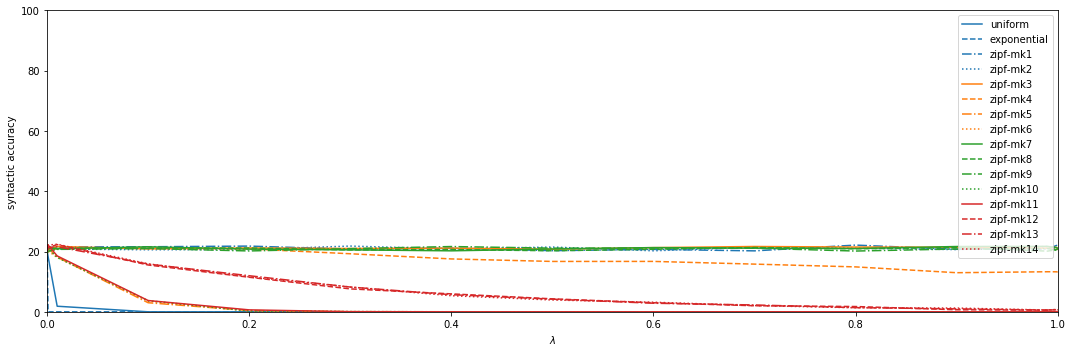

In [59]:
plot_accuracy(embedding_names, 'syntactic')

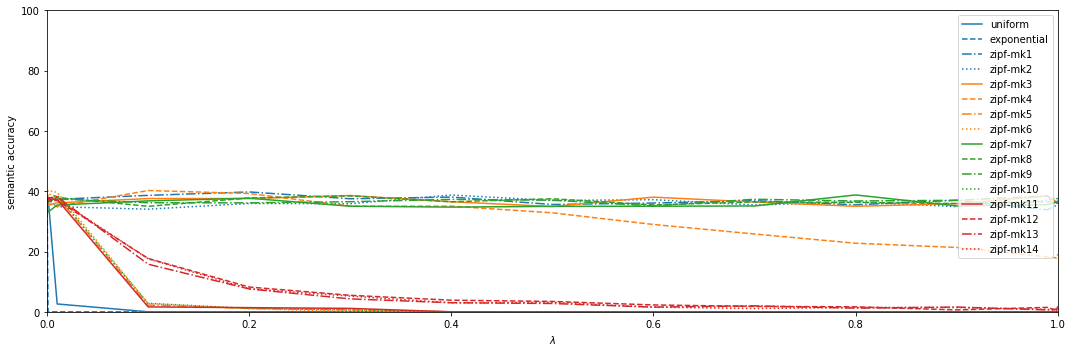

In [60]:
plot_accuracy(embedding_names, 'semantic')

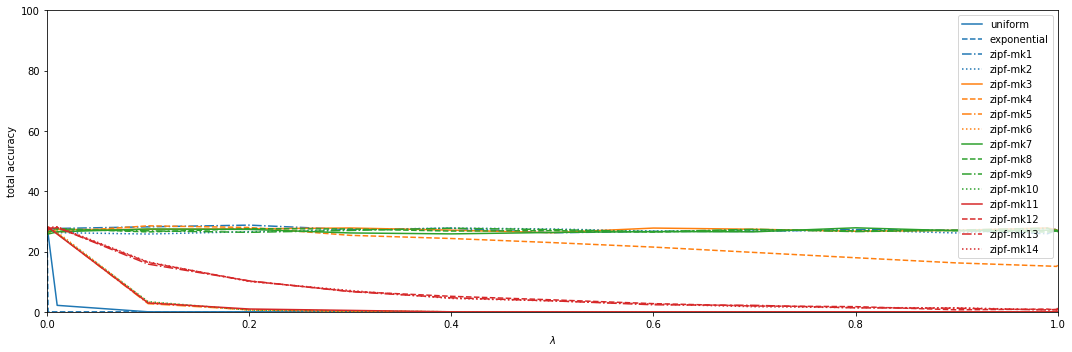

In [61]:
plot_accuracy(embedding_names, 'total')